Mounting the drive


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


Setting the Project path in the drive

In [0]:
project_path = "/content/drive/My Drive/GL/Computer_Vision/week 5/"

Loading the dataset

In [0]:
import numpy as np
data = np.load(project_path+'images.npy', allow_pickle=True)

Checking the sample from dataset

In [4]:
data[10][1]

[{'imageHeight': 337,
  'imageWidth': 600,
  'label': ['Face'],
  'notes': '',
  'points': [{'x': 0.48, 'y': 0.10385756676557864},
   {'x': 0.7716666666666666, 'y': 0.6795252225519288}]}]

In [5]:
data[50][1]

[{'imageHeight': 1096,
  'imageWidth': 1000,
  'label': ['Face'],
  'notes': '',
  'points': [{'x': 0.685807150595883, 'y': 0.24209486166007904},
   {'x': 0.7865655471289275, 'y': 0.43379446640316205}]}]

Setting Image dimension

In [0]:
IMAGE_WIDTH = 224
IMAGE_HEIGHT = 224

ALPHA = 1.0

Creating Features and Labels

In [0]:
import cv2
from tensorflow.keras.applications.mobilenet import preprocess_input

masks = np.zeros((int(data.shape[0]), IMAGE_HEIGHT, IMAGE_WIDTH))
X_train = np.zeros((int(data.shape[0]), IMAGE_HEIGHT, IMAGE_WIDTH, 3))
for index in range(data.shape[0]):
    img = data[index][0]
    img = cv2.resize(img, dsize=(IMAGE_HEIGHT, IMAGE_WIDTH), interpolation=cv2.INTER_CUBIC)
    try:
      img = img[:, :, :3]
    except:
      continue
    X_train[index] = preprocess_input(np.array(img, dtype=np.float32))
    for i in data[index][1]:
        x1 = int(i["points"][0]['x'] * IMAGE_WIDTH)
        x2 = int(i["points"][1]['x'] * IMAGE_WIDTH)
        y1 = int(i["points"][0]['y'] * IMAGE_HEIGHT)
        y2 = int(i["points"][1]['y'] * IMAGE_HEIGHT)
        masks[index][y1:y2, x1:x2] = 1

Shape of the data

In [8]:
X_train.shape

(409, 224, 224, 3)

In [9]:
masks.shape

(409, 224, 224)

Printing the Sample

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[[[ 0.45882356  0.47450984  0.57647061]
  [ 0.45882356  0.47450984  0.57647061]
  [ 0.47450984  0.49019611  0.59215689]
  ...
  [-0.72549021 -0.49803919 -0.16862744]
  [-0.75686276 -0.48235291 -0.30196077]
  [-0.74117649 -0.47450978 -0.27843136]]

 [[ 0.49803925  0.52941179  0.62352943]
  [ 0.49803925  0.52941179  0.62352943]
  [ 0.52941179  0.56078434  0.65490198]
  ...
  [-0.74901962 -0.52156866 -0.21568626]
  [-0.65490198 -0.38823527 -0.17647058]
  [-0.67058825 -0.40392154 -0.18431371]]

 [[ 0.44313729  0.47450984  0.56862748]
  [ 0.36470592  0.39607847  0.49019611]
  [ 0.41960788  0.45098042  0.54509807]
  ...
  [-0.65490198 -0.41960782 -0.13725489]
  [-0.84313726 -0.58431375 -0.32549018]
  [-0.85882354 -0.60000002 -0.34117645]]

 ...

 [[-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]
  ...
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]
  [-1.         -1.         -1.        ]]

 [

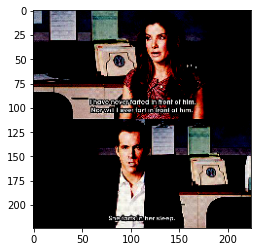

In [10]:
from matplotlib import pyplot
n = 5
print(X_train[n])
pyplot.imshow(X_train[n])

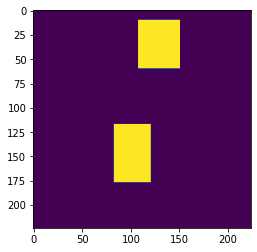

In [11]:
pyplot.imshow(masks[n])

Building the model

In [0]:
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.layers import Concatenate, UpSampling2D, Conv2D, Reshape
from tensorflow.keras.models import Model

In [0]:
def create_model(trainable=True):
    model = MobileNet(input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3), include_top=False, alpha=ALPHA, weights="imagenet")
    for layer in model.layers:
        layer.trainable = trainable
    # model.summary()
  
    block_1 = model.get_layer("conv_pw_1_relu").output
    block0 = model.get_layer("conv_pw_3_relu").output
    block1 = model.get_layer("conv_pw_5_relu").output
    block2 = model.get_layer("conv_pw_11_relu").output
    block3 = model.get_layer("conv_pw_13_relu").output

    x = Concatenate()([UpSampling2D()(block3), block2])
    print(x.shape)
    x = Concatenate()([UpSampling2D()(x), block1])
    print(x.shape)
    x = Concatenate()([UpSampling2D()(x), block0])
    print(x.shape)
    x = Concatenate()([UpSampling2D()(x), block_1])
    print(x.shape)
    x = UpSampling2D()(x)
    print(x.shape)
    x = Conv2D(1, kernel_size=1, activation="sigmoid")(x)
    x = Reshape((IMAGE_HEIGHT, IMAGE_WIDTH))(x)
    print(x.shape)
    return Model(inputs=model.input, outputs=x)

Calling the creating model and getting the summary

In [14]:
model = create_model(False)
model.summary()

17227776/17225924 [==============================] - 0s 0us/step
(None, 14, 14, 1536)
(None, 28, 28, 1792)
(None, 56, 56, 1920)
(None, 112, 112, 1984)
(None, 224, 224, 1984)
(None, 224, 224)
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 32) 864         conv1_pad[0][0]                  
__________________________________________________________________________________________________
co

Dice coeffiecient

In [0]:
def dice_coefficient(y_true, y_pred):
    numerator = 2 * tf.reduce_sum(y_true * y_pred)
    denominator = tf.reduce_sum(y_true + y_pred)

    return numerator / (denominator + tf.keras.backend.epsilon())

Defining Loss

In [0]:
import tensorflow as tf
from tensorflow.keras.losses import binary_crossentropy
def loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) - tf.math.log(dice_coefficient(y_true, y_pred) + tf.keras.backend.epsilon())

Compiling the model

In [0]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy

EPOCHS = 30

optimizer = Adam(lr=1e-3)
model.compile(loss=loss, optimizer=optimizer, metrics=[dice_coefficient])

Checkpoint and Earlystopping

In [0]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
checkpoint = ModelCheckpoint("model-{loss:.2f}.h5", monitor="loss", verbose=1, save_best_only=True,
                             save_weights_only=True, mode="min")
stop = EarlyStopping(monitor="loss", patience=5, mode="min")
reduce_lr = ReduceLROnPlateau(monitor="loss", factor=0.2, patience=5, min_lr=1e-6, verbose=1, mode="min")

In [0]:
from sklearn.model_selection import train_test_split

# Split train and valid
X_train, X_valid, y_train, y_valid = train_test_split(X_train, masks, test_size=0.15, random_state=2019)

Fitting the model

In [20]:
model.fit(X_train, y_train, epochs=EPOCHS, validation_data=(X_valid, y_valid), verbose=1, batch_size=10, callbacks=[checkpoint, reduce_lr, stop])

Epoch 1/30
35/35 [==============================] - ETA: 0s - loss: 1.3823 - dice_coefficient: 0.3790
Epoch 00001: loss improved from inf to 1.38230, saving model to model-1.38.h5
35/35 [==============================] - 18s 506ms/step - loss: 1.3823 - dice_coefficient: 0.3790 - val_loss: 0.9642 - val_dice_coefficient: 0.5482 - lr: 0.0010
Epoch 2/30
35/35 [==============================] - ETA: 0s - loss: 0.8647 - dice_coefficient: 0.5505
Epoch 00002: loss improved from 1.38230 to 0.86466, saving model to model-0.86.h5
35/35 [==============================] - 16s 466ms/step - loss: 0.8647 - dice_coefficient: 0.5505 - val_loss: 0.8472 - val_dice_coefficient: 0.5992 - lr: 0.0010
Epoch 3/30
35/35 [==============================] - ETA: 0s - loss: 0.7764 - dice_coefficient: 0.5902
Epoch 00003: loss improved from 0.86466 to 0.77635, saving model to model-0.78.h5
35/35 [==============================] - 16s 470ms/step - loss: 0.7764 - dice_coefficient: 0.5902 - val_loss: 0.8092 - val_dice_co

Getting the predicted mask for a sample image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


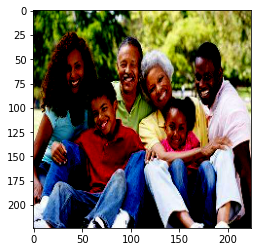

In [66]:
sample_image = X_train[33]
pyplot.imshow(sample_image)

In [0]:
pred_mask = model.predict(x=np.array([sample_image]))[0] > 0.6

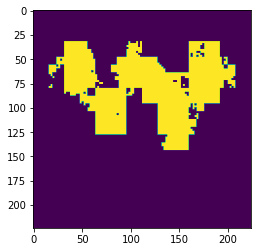

In [69]:
pyplot.imshow(pred_mask)

Imposing the mask on the image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


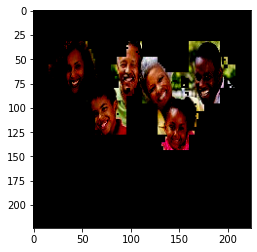

In [70]:
image2 = sample_image
image2[:,:,0] = pred_mask*sample_image[:,:,0]
image2[:,:,1] = pred_mask*sample_image[:,:,1]
image2[:,:,2] = pred_mask*sample_image[:,:,2]

out_image = image2

pyplot.imshow(out_image)

Getting predicted mask on validation image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


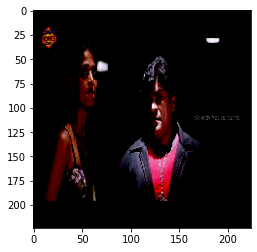

In [71]:
sample_image = X_valid[33]
pyplot.imshow(sample_image)

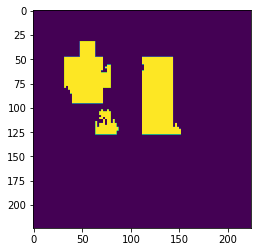

In [72]:
pred_mask = model.predict(x=np.array([sample_image]))[0] > 0.6
pyplot.imshow(pred_mask)

Imposing the predicted mask on validation image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


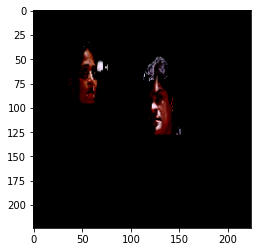

In [73]:
image2 = sample_image
image2[:,:,0] = pred_mask*sample_image[:,:,0]
image2[:,:,1] = pred_mask*sample_image[:,:,1]
image2[:,:,2] = pred_mask*sample_image[:,:,2]

out_image = image2

pyplot.imshow(out_image)